# **Final Model**

In [1]:
# importing all libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# reading data
df = pd.read_csv('data.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
# shape of dataset
df.shape

(381109, 12)

In [4]:
# removing unwanted columns
columns_to_remove = ['id', 'Driving_License']
df.drop(columns=columns_to_remove, inplace=True)

In [5]:
# reducing categories in region code column 
region_counts = df['Region_Code'].value_counts()
df['Region_Code'] = [i if region_counts[i] >= 6280 else 1.0 for i in df['Region_Code']]

# changing datatype to str
df['Region_Code'] = df['Region_Code'].astype(str)

In [6]:
# reducing categories in region code column
policy_sales_channel_count = df['Policy_Sales_Channel'].value_counts()
df['Policy_Sales_Channel'] = [i if policy_sales_channel_count[i] >= 1360 else 1.0 for i in df['Policy_Sales_Channel']]

# changing datatype to str
df['Policy_Sales_Channel'] =df['Policy_Sales_Channel'].astype(str)

In [7]:
# encoding vehicle age column
df['Vehicle_Age'] = df['Vehicle_Age'].map({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2}).astype(int)

In [8]:
df_encoded = pd.get_dummies(df, dtype=int, drop_first=True)
df_encoded.head()

,Age,Previously_Insured,Vehicle_Age,Annual_Premium,Vintage,Response,Gender_Male,Region_Code_11.0,Region_Code_15.0,Region_Code_28.0,Region_Code_29.0,Region_Code_3.0,Region_Code_30.0,Region_Code_33.0,Region_Code_35.0,Region_Code_36.0,Region_Code_41.0,Region_Code_46.0,Region_Code_47.0,Region_Code_50.0,Region_Code_6.0,Region_Code_8.0,Vehicle_Damage_Yes,Policy_Sales_Channel_122.0,Policy_Sales_Channel_124.0,Policy_Sales_Channel_13.0,Policy_Sales_Channel_151.0,Policy_Sales_Channel_152.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Policy_Sales_Channel_25.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_30.0,Policy_Sales_Channel_7.0,Policy_Sales_Channel_8.0
0,44,0,2,40454.0,217,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,76,0,1,33536.0,183,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,47,0,2,38294.0,27,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,21,1,0,28619.0,203,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,29,1,0,27496.0,39,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [9]:
# splitting data into X and y
X = df_encoded.drop(columns='Response')
y = df_encoded['Response']

In [10]:
# splitting data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [11]:
# capping values with maximum values (removing outliers)
X_train['Annual_Premium'] = [i if i < 61000 else 61000 for i in X_train['Annual_Premium']]

In [12]:
# random under sampling for balancing dataset
nn_under_sampler = RepeatedEditedNearestNeighbours(n_neighbors=4)
X_resampled, y_resampled = nn_under_sampler.fit_resample(X_train, y_train)

In [13]:
# printing shape of data
print("Shape of data before resampling:",X_train.shape)
print("Shape of data after resampling:",X_resampled.shape)
y_resampled.value_counts()

Shape of data before resampling: (342998, 37)
Shape of data after resampling: (181941, 37)


Response
0    140014
1     41927
Name: count, dtype: int64

In [14]:
columns_to_scale = ['Age', 'Annual_Premium', 'Vintage', 'Vehicle_Age']

scaler = MinMaxScaler()
X_resampled[columns_to_scale] = scaler.fit_transform(X_resampled[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [15]:
X_resampled

,Age,Previously_Insured,Vehicle_Age,Annual_Premium,Vintage,Gender_Male,Region_Code_11.0,Region_Code_15.0,Region_Code_28.0,Region_Code_29.0,Region_Code_3.0,Region_Code_30.0,Region_Code_33.0,Region_Code_35.0,Region_Code_36.0,Region_Code_41.0,Region_Code_46.0,Region_Code_47.0,Region_Code_50.0,Region_Code_6.0,Region_Code_8.0,Vehicle_Damage_Yes,Policy_Sales_Channel_122.0,Policy_Sales_Channel_124.0,Policy_Sales_Channel_13.0,Policy_Sales_Channel_151.0,Policy_Sales_Channel_152.0,Policy_Sales_Channel_154.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Policy_Sales_Channel_25.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_30.0,Policy_Sales_Channel_7.0,Policy_Sales_Channel_8.0
0,0.600000,0,0.5,0.319188,0.463668,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.046154,1,0.0,0.466661,0.242215,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0.061538,0,0.0,0.802142,0.868512,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0.076923,1,0.0,0.498235,0.622837,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0.184615,1,0.0,0.420815,0.446367,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181936,0.400000,0,0.5,0.520507,0.768166,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
181937,0.492308,0,0.5,0.414734,0.321799,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
181938,0.153846,0,0.0,0.411530,0.138408,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
181939,0.353846,0,0.5,0.451619,0.384083,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [16]:
print("Shape of training data is: ", X_resampled.shape)
print("Shape of testing data is: ", X_test.shape)

Shape of training data is:  (181941, 37)
Shape of testing data is:  (38111, 37)


Accuracy of the model is:  0.76
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     33328
           1       0.32      0.79      0.45      4783

    accuracy                           0.76     38111
   macro avg       0.64      0.77      0.65     38111
weighted avg       0.88      0.76      0.80     38111



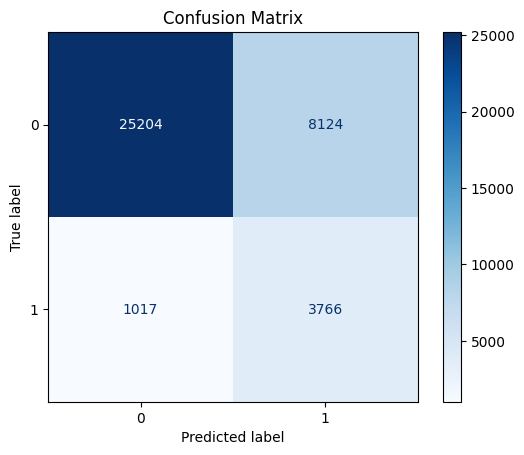

In [17]:
# training mode

# best parameters 
params = {
           'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 2, 
           'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8
         }

# training model
gbc = GradientBoostingClassifier(**params)
gbc.fit(X_resampled, y_resampled)

# making predictions
y_pred = gbc.predict(X_test)

# accuracy 
acc = accuracy_score(y_test, y_pred)
print("Accuracy of the model is: ", round(acc, 2))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')  # Use a colormap for better visualization
plt.title("Confusion Matrix")
plt.show()